In [1]:
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
import os
print(os.getcwd())
os.chdir('/home/vco/Projects/pm4py-dcr') # working directory should be pm4py-dcr (the one behind notebooks)
print(os.getcwd())

/home/vco/Projects/pm4py-dcr/notebooks
/home/vco/Projects/pm4py-dcr


In [2]:
#TODO: make a vectorized implementation of the mapping
# for now run the src/dcr_to_petri_readable.py file

import itertools
import pandas as pd

from copy import deepcopy
from itertools import combinations
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor,wait

from pm4py.objects.conversion.dcr.variants.to_petri_net import Dcr2PetriTransport
from pm4py.objects.dcr.importer import importer as dcr_importer
from pm4py.objects.petri_net.importer import importer as pnml_importer

/home/vco/Projects/pm4py-dcr/pm4py/objects/random_variables/__init__.py:21: UserWarning: The random_variables package will be removed in a future release.
  warnings.warn("The random_variables package will be removed in a future release.")


In [25]:
def run_one_dcrxml_all_optimizations_file(input_dcrxml_path, override=False, reachability_timeout=None):
    '''

    :param input_dcrxml_path: full path with extension
    :param reachability_timeout: timeout in seconds to search the reachability graph.
    :return:
    '''
    path_without_extension = os.path.splitext(input_dcrxml_path)[0]
    name_with_extension = os.path.basename(input_dcrxml_path)
    name = Path(input_dcrxml_path).stem
    format = 'tapn'
    dcrxml_files = [
        [input_dcrxml_path, f'{path_without_extension}_unoptimized.{format}', False, False, True,'unoptimized'],
        [input_dcrxml_path, f'{path_without_extension}_dcranalysis.{format}', True, False, False,'dcranalysis'],
        [input_dcrxml_path, f'{path_without_extension}_pnreachability.{format}', False, True, False,'pnreachability'],
        [input_dcrxml_path, f'{path_without_extension}_fulloptimization.{format}', True, True, False,'fulloptimization'],
    ]
    for mapping_call in dcrxml_files:
        if os.path.isfile(mapping_call[1]) and not override:
            print(f'[i] File {Path(mapping_call[1]).stem} already exists.')
            pass
        else:
            d2p = Dcr2PetriTransport(preoptimize=mapping_call[2], postoptimize=mapping_call[3],
                                     map_unexecutable_events=mapping_call[4],debug=False)
            d2p.print_steps = True
            d2p.reachability_timeout = 60*10 #10 minutes
            if reachability_timeout:
                d2p.reachability_timeout = reachability_timeout
            print(f'[i] Import {mapping_call[0]}')
            dcr = dcr_importer.apply(mapping_call[0])
            print(f'[i] Converting {mapping_call[0]} as {mapping_call[5]}')
            tapn, m = d2p.dcr2tapn(dcr, tapn_path=mapping_call[1])
            print(f'[i] Done for: {mapping_call[0]}!')

run_one_dcrxml_all_optimizations_file('models/today.xml',override=True)

[i] Import models/today.xml
[i] Converting models/today.xml as unoptimized
[i] mapping events
[i] map constraining relations
[i] map effect relations
[i] handle all relation exceptions
[i] export to models/today_unoptimized.tapn
[i] Done for: models/today.xml!
[i] Import models/today.xml
[i] Converting models/today.xml as dcranalysis
[i] preoptimizing
[i] finding exceptional behaviour
[i] mapping events
[i] map constraining relations
[i] map effect relations
[i] handle all relation exceptions
[i] export to models/today_dcranalysis.tapn
[i] Done for: models/today.xml!
[i] Import models/today.xml
[i] Converting models/today.xml as pnreachability
[i] mapping events
[i] map constraining relations
[i] map effect relations
[i] handle all relation exceptions
[i] post optimizing
[i] export to models/today_pnreachability.tapn
[i] Done for: models/today.xml!
[i] Import models/today.xml
[i] Converting models/today.xml as fulloptimization
[i] preoptimizing
[i] finding exceptional behaviour
[i] map

In [3]:
def prepare_all_permutations():
    dcr_template = {
        'events': set(),
        'conditionsFor': {},
        'milestonesFor': {},
        'responseTo': {},
        'noResponseTo': {},
        'includesTo': {},
        'excludesTo': {},
        'conditionsForDelays': {},
        'responseToDeadlines': {},
        'marking': {'executed': set(),
                    'included': set(),
                    'pending': set()
                    }
    }
    effect_relations = ['includesTo', 'excludesTo', 'responseTo']# 'noResponseTo']
    constrain_relations = ['conditionsFor']#, 'milestonesFor']
    all_relations = effect_relations + constrain_relations
    e1 = 'A'
    e2 = 'B'
    dcrs_to_test = {}
    for j in [1, 2]:
        for i in range(6, 0, -1):
            for comb in combinations(all_relations, i):
                if j == 1:
                    for (ai, ae, ap) in itertools.product([True, False], repeat=3):
                        dcr = deepcopy(dcr_template)
                        dcr['events'] = {e1}
                        if ai:
                            dcr['marking']['included'] = {e1}
                        if ae:
                            dcr['marking']['executed'] = {e1}
                        if ap:
                            dcr['marking']['pending'] = {e1}
                        for rel in comb:
                            if not e1 in dcr[rel]:
                                dcr[rel][e1] = set()
                            dcr[rel][e1].add(e1)
                        key = f'self_{repr(comb)}_A{1 if ai else 0}{1 if ae else 0}{1 if ap else 0}'
                        dcrs_to_test[key] = dcr
                else:
                    for (ai, ae, ap, bi, be, bp) in itertools.product([True, False], repeat=6):
                        dcr = deepcopy(dcr_template)
                        dcr['events'] = {e1, e2}
                        if ai:
                            dcr['marking']['included'].add(e1)
                        if ae:
                            dcr['marking']['executed'].add(e1)
                        if ap:
                            dcr['marking']['pending'].add(e1)
                        if bi:
                            dcr['marking']['included'].add(e2)
                        if be:
                            dcr['marking']['executed'].add(e2)
                        if bp:
                            dcr['marking']['pending'].add(e2)
                        for rel in comb:
                            if rel in constrain_relations:
                                if not e2 in dcr[rel]:
                                    dcr[rel][e2] = set()
                                dcr[rel][e2].add(e1)
                            else:
                                if not e1 in dcr[rel]:
                                    dcr[rel][e1] = set()
                                dcr[rel][e1].add(e2)
                        key = f'rel_{repr(comb)}_A{1 if ai else 0}{1 if ae else 0}{1 if ap else 0}_B{1 if bi else 0}{1 if be else 0}{1 if bp else 0}'
                        # if key.replace("'", "").replace("(", "").replace(")", "").replace(",", "").replace(" ", "_") == 'rel_conditionsFor_A100_B100':
                        #     print(dcr)
                        dcrs_to_test[key] = dcr
    return dcrs_to_test


def complete_test(dcrs_to_test):
    past_k = None
    i = 0
    counter = 0
    for k, v in dcrs_to_test.items():
        k_split = k.split('_')
        file_name = k.replace("'", "").replace("(", "").replace(")", "").replace(",", "").replace(" ", "_")
        file_name = file_name + ".tapn"
        res_path = f"models/all/{file_name}"
        d2p = Dcr2PetriTransport(preoptimize=True, postoptimize=True, map_unexecutable_events=False)
        tapn = d2p.dcr2tapn(v, res_path)
        if k_split[1] != past_k:
            # print(f'[i] {k}')
            i = i + 1
            past_k = k_split[1]
        counter = counter + 1


def run_all():
    '''
    this runs all permutations of 1 to 2 events and 1 to 6 relations and all of their possible markings
    '''
    print('[i] Running all permutations of 1 to 2 events and 1 to 4 relations and all of their possible markings')
    dcrs_to_test = prepare_all_permutations()
    complete_test(dcrs_to_test)
    print('[i] Done all permutations of 1 to 2 events and 1 to 4 relations and all of their possible markings')

def run_eshop_files():
    '''
    here you can specify which files you want to execute in a matrix
    the matrix structure is as follows:
       each line is an input for 1 execution
       one line has the following parameters:
       [source file name under models/dcrxml, destination tapn file name, if it should preoptimize, if it should postoptimize, if it should map unexecutable events]

    Remember to create the models folder at the same level as the src folder and inside the models folder create the dcrxml folder
    '''
    dcrxml_files = [
        # ['test_specific_mapping.xml', 'test_specific_mapping_unoptimized.tapn', True, False, False],  # i=0
        # ['test_specific_mapping.xml', 'test_specific_mapping.tapn', False, True, True],  # i=1 etc.
        # ['DCR_Indicators_220810_Fix2.xml', 'dcr_indicators_fix2_unoptimized.tapn', True, False, False],
        # ['DCR_Indicators_220810_Fix2.xml', 'dcr_indicators_fix2.tapn', False, True, True],
        # ['DCR_Indicators_220906_Fulllog.xml', 'dcr_indicators_full.tapn', False, True, True],
        # ['Road Traffic Fine.xml', 'road_traffic_fine_unoptimized.tapn', True, False, False],
        # ['Expense report example.xml', 'expense_report_unoptimized.tapn', True, False, False],
        # ['Road Traffic Fine.xml', 'road_traffic_fine.tapn', False, True, True],
        # ['Expense report example.xml', 'expense_report.tapn', False, True, True],  # i=8
        ['eshop.xml', 'eshop_unoptimized.pnml', False, False, True],
        ['eshop.xml', 'eshop_dcr_analysis.pnml', True, False, False],
        ['eshop.xml', 'eshop_pn_reachability.pnml', False, True, False],
        ['eshop.xml', 'eshop_full_optimization.pnml', True, True, False],
    ]
    # this runs from i=5 to 8 (so the road traffic fine and expense report optimized and unoptimized conversions
    for mapping_call in dcrxml_files:
        # mapping_call = dcrxml_files[i]
        d2p = Dcr2PetriTransport(preoptimize=mapping_call[2], postoptimize=mapping_call[3],
                                 map_unexecutable_events=mapping_call[4])
        d2p.print_steps = True
        print(f'[i] import {mapping_call[0]}')
        dcr = dcr_importer.apply(f'models/{mapping_call[0]}')
        print(f'[i] convert {mapping_call[0]}')
        tapn, m = d2p.dcr2tapn(dcr, tapn_path=f"models/{mapping_call[1]}")

# uncomment which one you need and read more in the function about what it does
# run_all()  # runs all possible 1,2 event and relation combinations (see the method definition and comments above)
# run_specific_dcr()  # runs a user defined dcr graph written as a python dict (see the method definition and comments above)
run_eshop_files()  # runs on specific dcrxml files (see the method definition and comments above)
print('[i] Done!')

[i] import eshop.xml
[i] convert eshop.xml
[i] mapping events
[i] map constraining relations
[i] map effect relations
[i] handle all relation exceptions
[i] export to models/eshop_unoptimized.pnml
[i] import eshop.xml
[i] convert eshop.xml
[i] preoptimizing
[i] finding exceptional behaviour
[i] mapping events
[i] map constraining relations
[i] map effect relations
[i] handle all relation exceptions
[i] export to models/eshop_dcr_analysis.pnml
[i] import eshop.xml
[i] convert eshop.xml
[i] mapping events
[i] map constraining relations
[i] map effect relations
[i] handle all relation exceptions
[i] post optimizing
[i] export to models/eshop_pn_reachability.pnml
[i] import eshop.xml
[i] convert eshop.xml
[i] preoptimizing
[i] finding exceptional behaviour
[i] mapping events
[i] map constraining relations
[i] map effect relations
[i] handle all relation exceptions
[i] post optimizing
[i] export to models/eshop_full_optimization.pnml
[i] Done!


# Todays example

In [12]:
def run_dcr_xml(file_name):
    dcrxml_files = [
        # [file_name, 'today_unoptimized.pnml', False, False, True],
        # [file_name, 'today_dcr_analysis.pnml', True, False, False],
        # [file_name, 'today_pn_reachability.pnml', False, True, False],
        [file_name, 'today_full_optimization.pnml', True, True, False],
    ]
    # this runs from i=5 to 8 (so the road traffic fine and expense report optimized and unoptimized conversions
    for mapping_call in dcrxml_files:
        # mapping_call = dcrxml_files[i]
        d2p = Dcr2PetriTransport(preoptimize=mapping_call[2], postoptimize=mapping_call[3],
                                 map_unexecutable_events=mapping_call[4],debug=True)
        d2p.print_steps = True
        print(f'[i] import {mapping_call[0]}')
        dcr = dcr_importer.apply(f'models/{mapping_call[0]}')
        print(dcr)
        print(f'[i] convert {mapping_call[0]}')
        tapn, m = d2p.dcr2tapn(dcr, tapn_path=f"models/{mapping_call[1]}")
        print(tapn)

run_dcr_xml('today.xml')
print('[i] Done!')

[i] import today.xml
{'events': {'Talk_about_pm4py', 'Leave_DTU', 'Finish_Presentation', 'Demo_ran_without_issues', 'Arrived_at_DTU', 'Start_presentation', 'Interest_in_pm4py', 'Questions', 'Had_lunch'}, 'labels': {'Demo ran without issues', 'Had lunch', 'Talk about pm4py', 'Leave DTU', 'Arrived at DTU', 'Interest in pm4py', 'Questions', 'Start presentation', 'Finish Presentation'}, 'labelMapping': {'ArrivedatDTU': {'Arrived_at_DTU'}, 'Hadlunch': {'Had_lunch'}, 'Startpresentation': {'Start_presentation'}, 'Talkaboutpm4py': {'Talk_about_pm4py'}, 'FinishPresentation': {'Finish_Presentation'}, 'Questions': {'Questions'}, 'Demoranwithoutissues': {'Demo_ran_without_issues'}, 'Interestinpm4py': {'Interest_in_pm4py'}, 'LeaveDTU': {'Leave_DTU'}}, 'conditionsFor': {'Start_presentation': {'Arrived_at_DTU'}, 'Questions': {'Start_presentation'}, 'Demo_ran_without_issues': {'Start_presentation'}, 'Interest_in_pm4py': {'Start_presentation'}, 'Finish_Presentation': {'Start_presentation'}}, 'milestone

D# Analysis on the Datasets folder

In [ ]:
def run_analysis_on_pnmls(datasets_folder):

    pnml_res = []

    for root, dirs, files in os.walk(datasets_folder):
        for file in files:
            if file.endswith(".dcrxml"):
                pnml_res.append(os.path.join(root, file))

    analysis_results = {}
    for pnml in pnml_res:
        path_without_extension = os.path.splitext(pnml)[0]
        name_with_extension = os.path.basename(pnml)
        name = Path(pnml).stem
        version = name.split('_')[-1]
        # analysis
        tapn = pnml_importer.apply(pnml)
        analysis_results[name] = {}
        analysis_results[name]['version'] = version
        analysis_results[name]['#places'] = len(tapn.places)
        analysis_results[name]['#transitions'] = len(tapn.transitions)
        analysis_results[name]['#arcs'] = len(tapn.arcs)
    df = pd.DataFrame(analysis_results).T
    df.to_csv('models/analysis/optimization_analysis.csv')

def run_dcrxml_files(folder_with_dcr_xmls,override=False):
    dcrxml_res = []

    for root, dirs, files in os.walk(folder_with_dcr_xmls):
        for file in files:
            if file.endswith(".dcrxml"):
                dcrxml_res.append(os.path.join(root, file))
    # dcrxml_res2 = []
    # for dcrxml in dcrxml_res:
    #     if dcrxml.count('/')>4:
    #         dcrxml_res2.append(dcrxml)

    with ThreadPoolExecutor(16) as tpe:
            # futures = [tpe.submit(print, dcrxml) for dcrxml in dcrxml_res]
            futures = [tpe.submit(run_one_dcrxml_all_optimizations_file, dcrxml,override,2*60) for dcrxml in dcrxml_res]
    # with ThreadPoolExecutor(16) as tpe:
    #         # futures = [tpe.submit(print, dcrxml) for dcrxml in dcrxml_res]
    #         futures = [tpe.submit(run_one_dcrxml_all_optimizations_file, dcrxml,override,2*60) for dcrxml in dcrxml_res2]
    #         # for future in futures:
    #             # res = future.result(timeout=10*60)
    #             # print(f'[i] res: {res}')
    # exceptions = ['/home/vco/Datasets/12688511/CoSeLoG WABO 2.dcrxml',
    #               '/home/vco/Datasets/12681647/XES-files/event_log_choice_2_10000.dcrxml',
    #               '/home/vco/Datasets/12681647/XES-files/event_log_sequence_100_10000.dcrxml'
    #               ]
    # for dcrxml in dcrxml_res2:
    #     if dcrxml not in exceptions:
    #         run_one_dcrxml_all_optimizations_file(dcrxml, False, 2*60)


def run_one_dcrxml_all_optimizations_file(input_dcrxml_path, override=False, reachability_timeout=None):
    '''

    :param input_dcrxml_path: full path with extension
    :param reachability_timeout: timeout in seconds to search the reachability graph.
    :return:
    '''
    path_without_extension = os.path.splitext(input_dcrxml_path)[0]
    name_with_extension = os.path.basename(input_dcrxml_path)
    name = Path(input_dcrxml_path).stem

    dcrxml_files = [
        # [input_dcrxml_path, f'{path_without_extension}_unoptimized.pnml', False, False, True,'unoptimized'],
        [input_dcrxml_path, f'{path_without_extension}_dcranalysis.pnml', True, False, False,'dcranalysis'],
        # [input_dcrxml_path, f'{path_without_extension}_pnreachability.pnml', False, True, False,'pnreachability'],
        [input_dcrxml_path, f'{path_without_extension}_fulloptimization.pnml', True, True, False,'fulloptimization'],
    ]
    for mapping_call in dcrxml_files:
        if os.path.isfile(mapping_call[1]) and not override:
            print(f'[i] File {Path(mapping_call[1]).stem} already exists.')
            pass
        else:
            d2p = Dcr2PetriTransport(preoptimize=mapping_call[2], postoptimize=mapping_call[3],
                                     map_unexecutable_events=mapping_call[4],debug=False)
            d2p.print_steps = True
            d2p.reachability_timeout = 60*10 #10 minutes
            if reachability_timeout:
                d2p.reachability_timeout = reachability_timeout
            print(f'[i] Import {mapping_call[0]}')
            dcr = dcr_importer.apply(mapping_call[0])
            print(f'[i] Converting {mapping_call[0]} as {mapping_call[5]}')
            tapn, m = d2p.dcr2tapn(dcr, tapn_path=mapping_call[1])
            print(f'[i] Done for: {mapping_call[0]}!')

# run_one_dcrxml_all_optimizations_file('/home/vco/Datasets/Hospital_log.dcrxml')
# run_one_dcrxml_all_optimizations_file('/home/vco/Datasets/12683249/Road_Traffic_Fine_Management_Process.dcrxml',override=True)
#run_one_dcrxml_all_optimizations_file('/home/vco/Projects/dcr-to-tapn/models/results/Road_Traffic_Fine_Management_Process.dcrxml', override=True)
# run_one_dcrxml_all_optimizations_file('/home/vco/Projects/dcr-to-tapn/models/debug/Road_Traffic_Fine_Management_Process_test.dcrxml', override=True)
# run_dcrxml_files('/home/vco/Datasets/')

run_dcrxml_files('models/results/', override=True)
print('[i] Done!')


# Other miners vs the DisCoveR -> PNirp model

In [5]:
import pm4py
from pm4py.discovery import discover_petri_net_inductive

In [2]:
rtfmp_log_path = '/home/vco/Datasets/12683249/Road_Traffic_Fine_Management_Process.xes'
bpic17_log_path = '/home/vco/Datasets/BPI Challenge 2017 - Offer log.xes'
sepsis_log_path = '/home/vco/Datasets/Sepsis Cases - Event Log.xes'

In [3]:
rtfmp_log = pm4py.read_xes('/home/vco/Datasets/12683249/Road_Traffic_Fine_Management_Process.xes')

/home/vco/.pyenv/versions/3.11.0/envs/pm4py-dcr/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 150370/150370 [00:17<00:00, 8613.60it/s] 


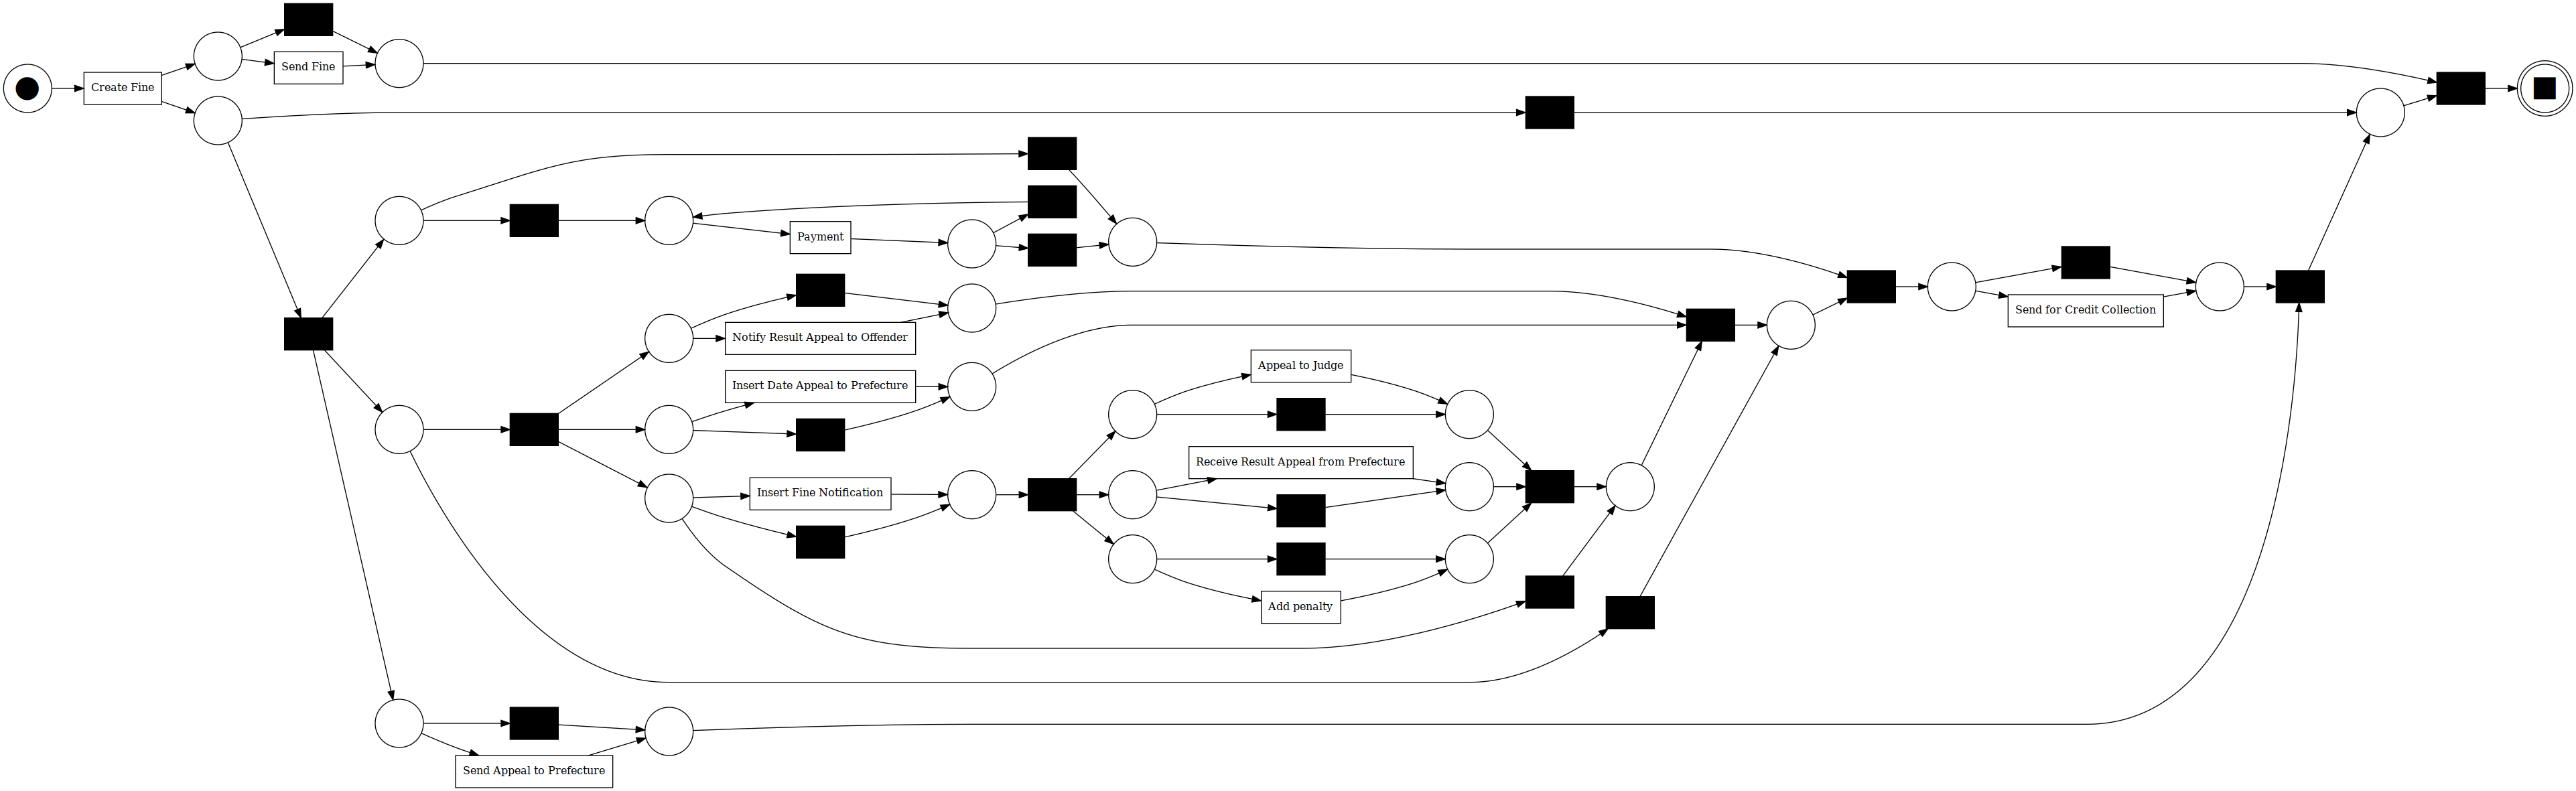

In [8]:
net2, im2, fm2 = pm4py.discover_petri_net_inductive(rtfmp_log)
pm4py.view_petri_net(net2, im2, fm2)

In [9]:
pm4py.save_vis_petri_net(net2,im2,fm2,'/home/vco/Presentation/im_rtfmp.png')

In [11]:
len(net2.places)

29

In [12]:
len(net2.transitions)

35

In [10]:
len(net2.arcs)

84